In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
%%capture
!pip install umap-learn

In [3]:
# --- Imports standard de la librairie Python ---
import os
from typing import List

# --- Imports de bibliothèques tierces ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import umap.umap_ as umap

In [4]:
###############################################################################
# NOTE : L'algorithme va ajouter deux colonnes 'umap_x' et 'umap_y' dans le
#        DataFrame et donc dans le CSV final. Ces colonnes contiendront les
#        coordonnées des points dans l'espace réduit à deux dimensions par UMAP.
###############################################################################

In [5]:
###############################################################################
#                          BLOC DE CONFIGURATION                              #
###############################################################################

# 1) PARAMÈTRES GÉNÉRAUX

# Chemin vers le dossier qui contient le CSV
folder_path = '/content/drive/MyDrive/COLAB_NLP/DATA/'

# Nom du fichier CSV
csv_file = "transcripts.csv"

# 2) SÉLECTION DES COLONNES POUR UMAP
# Les colonnes spécifiées ici doivent contenir des données numériques (int ou float).
# Si elles sont catégorielles ou textuelles, vous devez d’abord
# les encoder (pour les donnnées catégorielles) ou les vectoriser (pour les données textuelles).
# SÉLECTION DES COLONNES POUR UMAP
# =================================

# COLONNES NUMÉRIQUES
# ----------------------
# Listez ici les colonnes qui sont déjà au format numérique
# (int ou float) et que vous souhaitez utiliser directement
# dans l’algorithme UMAP.

numeric_columns_for_umap = [
    "video_view_count",
    "video_like_count",
    "video_comment_count",
    "sentiment"
]


# COLONNES CATÉGORIELLES
# --------------------------
# Listez ici les colonnes qui sont de type catégoriel
# (ex. "country", "language", "video_category", etc.).
# L'algorithme se chargera de les encoder en format numérique.

categorical_columns = [
    "channel_title",
]


# 3) PAS DE COLONNES TEXTUELLES.
# ---------------------
# Les colonnes textuelles ne sont pas gérées automatiquement.
# Elles nécessitent une vectorisation préalable (TF-IDF, BERT, etc.).


# 3) PARAMÈTRES PRINCIPAUX DE L'ALGORITHME UMAP

# n_neighbors :
#   - Définit le nombre de voisins (voisins locaux) pris en compte par l’algorithme UMAP
#     lors de la construction de la représentation. C’est la « portée » du regard local
#     autour de chaque point.
#   - Sur le plan méthodologique, plus n_neighbors est faible, plus l’algorithme
#     privilégie la structuration locale (petits clusters serrés). À l’inverse,
#     des valeurs plus élevées (par ex. 50+) font émerger une structuration plus globale,
#     où les nuances fines entre petits groupes risquent d’être moins marquées.
#   - Épistémologiquement, choisir n_neighbors revient à déterminer la finesse de la lecture
#     de l’espace : souhaite-t-on analyser la proximité de quelques points très similaires
#     (vision locale) ou préfère-t-on souligner la continuité et la cohérence
#     d’ensembles plus larges (vision globale) ?
#   - Une valeur trop faible de n_neighbors peut « hyper-segmenter » la représentation,
#     en isolant de petits groupes qui pourraient manquer d’homogénéité au niveau supérieur.
#     À l’inverse, une valeur trop élevée peut diluer des liens réels entre points,
#     écrasant d’éventuelles micro-structures intéressantes.
#   - Le choix de n_neighbors s’effectue donc en fonction de la nature attendue
#     (ou exploratoire) des groupes dans vos données et du degré de granularité désiré
#     dans votre analyse. Il n’existe pas de valeur universellement optimale.
n_neighbors = 10

# min_dist :
#   - Détermine la distance minimale autorisée entre les points dans l'espace UMAP.
#   - Concrètement, plus min_dist est petit, plus les points (observations) jugés très similaires
#     peuvent se retrouver « collés » dans la projection.
#   - À l’inverse, une valeur grande de min_dist « étale » davantage la projection et éloigne
#     les points les uns des autres, même s’ils sont relativement proches.
#   - Sur le plan méthodologique, min_dist influe sur l’équilibre entre la perception
#     des petits groupes fortement corrélés (clusters serrés) et la vision plus globale
#     de la répartition des données (clusters plus dispersés).
#   - Épistémologiquement, le choix de min_dist reflète l’importance que l’on accorde
#     à la structure locale (petits groupes très homogènes) ou à la structure globale
#     (vision plus lisse et moins localisée). Choisir une valeur trop faible peut conduire
#     à des regroupements excessivement serrés (risque d’« hyper-segmentation »), tandis
#     qu’une valeur trop élevée peut diluer la signification de proximités réelles
#     entre les observations.
#   - Il n’y a pas de « bonne » valeur universelle : tout dépend du degré de granularité
#     que l’on recherche dans l’analyse et de l’architecture réelle (ou supposée)
#     de l’espace à projeter.
min_dist = 0.2

# n_components :
#   - Nombre de dimensions de l'espace dans lequel on souhaite projeter les données.
#   - Généralement 2 pour faire un scatter plot, ou 3 pour visualiser en 3D.
#   - Pour de la réduction de dimension sans visualisation, on peut choisir > 2 (ex. 10 ou 20).
n_components = 2

In [6]:
def detect_separator(csv_file_path: str) -> str:
    """
    Détecte s’il y a plus de virgules ou de points-virgules dans la première ligne
    du fichier pour faire un guess sur le délimiteur (',' ou ';').
    """
    with open(csv_file_path, 'r', encoding='utf-8') as f:
        first_line = f.readline()
    nb_commas = first_line.count(',')
    nb_semicolons = first_line.count(';')
    return ';' if nb_semicolons > nb_commas else ','

In [7]:
def load_data(csv_file_path: str) -> pd.DataFrame:
    """
    1. Détecte le séparateur via detect_separator().
    2. Charge les données avec pandas.
    """
    # Détection du séparateur
    sep_found = detect_separator(csv_file_path)
    print(f"[*] Séparateur détecté : '{sep_found}'")

    # Lecture du fichier CSV
    df = pd.read_csv(csv_file_path, sep=sep_found, encoding='utf-8')
    print(f"[*] CSV chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes.")

    return df, sep_found

In [8]:
def apply_umap(df: pd.DataFrame,
               numeric_columns_for_umap: List[str],
               categorical_columns: List[str],
               features: List[str],
               n_neighbors: int = 15,
               min_dist: float = 0.1,
               n_components: int = 2,
               n_jobs=-1
               ) -> pd.DataFrame:
    """
    1. Sélectionne uniquement les colonnes d’intérêt (features).
    2. Applique un MinMaxScaler sur ces colonnes pour les ramener dans l'intervalle [0, 1].
    3. Applique une transformation UMAP sur ces données mises à l'échelle.
    4. Retourne un DataFrame contenant les composantes UMAP,
       dont les noms de colonnes intègrent :
         - l'indice de la composante (1, 2, etc.)
         - la valeur de n_neighbors
         - la valeur de min_dist
         - les noms ORIGINAUX des colonnes numériques et catégorielles.
    """

    # 0) Vérification de l'existence des colonnes dans df
    for col in features:
        if col not in df.columns:
            raise ValueError(f"La colonne '{col}' est introuvable dans le DataFrame.")

    # 1) Extraction des données d’intérêt
    data_for_umap = df[features].values

    # 2) Application du MinMaxScaler (chaque feature sera ramenée dans [0, 1])
    scaler = MinMaxScaler()
    data_for_umap_scaled = scaler.fit_transform(data_for_umap)

    # 3) Initialisation de l'objet UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        random_state=None,
        n_jobs=n_jobs
    )

    # 4) Exécution de la réduction de dimension sur les données scalées
    print("[*] Application de UMAP...")
    embedding = reducer.fit_transform(data_for_umap_scaled)
    print("[*] UMAP terminé.")

    # 5) Construction d'une chaîne descriptive à partir des paramètres
    #    et des listes "originales" de colonnes (numériques + catégorielles)
    #    On joint les noms avec "_", en séparant num(...) et cat(...).
    numeric_str = "_".join(numeric_columns_for_umap) or "None"
    cat_str = "_".join(categorical_columns) or "None"

    # 6) Création des noms de colonnes UMAP
    #    Exemple : UMAP_1_nn15_md0.1_num(video_view_count_video_like_count)_cat(video_category)
    columns = [
        f"UMAP_{i+1}_nn{n_neighbors}_md{min_dist}_num({numeric_str})_cat({cat_str})"
        for i in range(n_components)
    ]

    # 7) Construction du DataFrame des composantes UMAP
    df_umap = pd.DataFrame(embedding, columns=columns, index=df.index)

    return df_umap

In [9]:
def visualize_umap(df: pd.DataFrame,

                   df_umap: pd.DataFrame,
                   color_col: str = None,
                   title: str = "UMAP"):
    """
    Crée un scatter plot épuré des deux premières composantes UMAP.

    1. Concatène le DataFrame original et celui des coordonnées UMAP.
    2. Identifie automatiquement les deux premières colonnes UMAP
       (celles dont le nom commence par 'UMAP_' par exemple).
    3. Crée un scatterplot des deux premières composantes.
    """

    # Concatène df et df_umap
    df_plot = pd.concat([df, df_umap], axis=1)

    # On récupère automatiquement les noms de colonnes correspondant aux 2 premières composantes UMAP
    # (par exemple, toutes les colonnes qui commencent par "UMAP_")
    umap_cols = [col for col in df_umap.columns if col.startswith("UMAP_")]

    # S'il y a au moins 2 colonnes UMAP, on les prend comme x et y
    if len(umap_cols) < 2:
        raise ValueError("Le DataFrame df_umap doit contenir au moins deux colonnes dont le nom commence par 'UMAP_'.")

    x_col = umap_cols[0]
    y_col = umap_cols[1]

    plt.figure(figsize=(8, 6))

    # Si on souhaite colorer les points selon color_col, on passe cette colonne en paramètre à seaborn
    if color_col and color_col in df_plot.columns:
        sns.scatterplot(
            x=x_col,
            y=y_col,
            hue=color_col,
            data=df_plot,
            palette="viridis",
            alpha=0.7,
            legend=False
        )
    else:
        # Sinon, on fait un simple scatter plot
        plt.scatter(df_plot[x_col], df_plot[y_col], alpha=0.7)

    # Supprime les axes
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.gca().spines[['top', 'right', 'bottom', 'left']].set_visible(False)

    # Titre
    plt.title(title)

    plt.show()

In [10]:
def main(
    folder_path,
    csv_file,
    numeric_columns_for_umap,
    categorical_columns,
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    color_column=None
):
    # 1) Construit le chemin complet vers le CSV
    full_csv_path = os.path.join(folder_path, csv_file)

    # 2) Chargement des données
    df, sep_found = load_data(full_csv_path)
    print(f"[*] Données chargées depuis {full_csv_path} (séparateur détecté: '{sep_found}')")

    # 3) Encodage des colonnes catégorielles
    if categorical_columns:
        print("[*] Encodage des colonnes catégorielles...")
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

        encoded_array = encoder.fit_transform(df[categorical_columns])
        encoded_col_names = encoder.get_feature_names_out(categorical_columns)
        df_encoded = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df.index)

        # On crée ici la liste des colonnes encodées pour UMAP
        encoded_columns_for_umap = list(encoded_col_names)
    else:
        df_encoded = pd.DataFrame(index=df.index)  # DataFrame vide, même index
        encoded_columns_for_umap = []
        print("[*] Aucune colonne catégorielle à encoder.")

    # 4) Construction du DataFrame de travail pour UMAP
    # ------------------------------------------------------------------
    # On n'ajoute PAS d'encodage directement à `df` pour ne pas polluer
    # le DF original. On crée plutôt un DF spécial, df_for_umap.
    #
    # - On prend les colonnes numériques directement dans df
    # - On concatène avec df_encoded (les colonnes encodées seulement)
    # ------------------------------------------------------------------
    df_for_umap = pd.concat(
        [df[numeric_columns_for_umap], df_encoded],
        axis=1
    )

    # Cette liste globale de features comprend :
    # - les colonnes numériques
    # - les colonnes encodées
    features_for_umap = numeric_columns_for_umap + encoded_columns_for_umap

    # 5) Application de UMAP (sur df_for_umap plutôt que sur df)
    df_umap = apply_umap(
        df_for_umap,
        numeric_columns_for_umap=numeric_columns_for_umap,
        categorical_columns=categorical_columns,
        features=features_for_umap,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components
    )

    # 6) Visualisation
    # Ici, on transmet df original et df_umap pour la coloration éventuelle.
    visualize_umap(df, df_umap, color_col=color_column, title="UMAP")

    # 7) Sauvegarde
    # ----------------------------------------------------------------
    # On concatène SEULEMENT df (clean) + df_umap (les composantes UMAP).
    # => Les colonnes OneHot n’apparaîtront pas dans le CSV final.
    # ----------------------------------------------------------------
    output_path = os.path.join(folder_path, csv_file)
    df_concat = pd.concat([df, df_umap], axis=1)
    df_concat.to_csv(output_path, index=False, sep=sep_found, encoding='utf-8')

    print("[*] Script terminé avec succès.")

[*] Séparateur détecté : ';'
[*] CSV chargé : 26108 lignes, 15 colonnes.
[*] Données chargées depuis /content/drive/MyDrive/COLAB_NLP/DATA/transcripts.csv (séparateur détecté: ';')
[*] Encodage des colonnes catégorielles...
[*] Application de UMAP...


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[*] UMAP terminé.


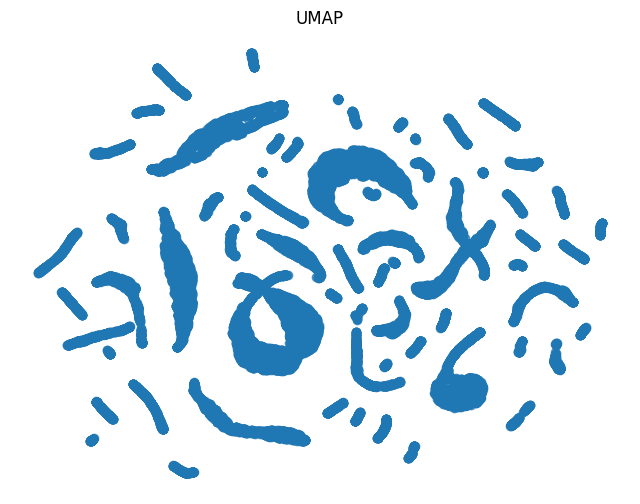

[*] Script terminé avec succès.


In [11]:
if __name__ == "__main__":
    main(folder_path,
         csv_file,
         numeric_columns_for_umap,
         categorical_columns)